# Generate network of genes and proteins up/down regulated by NANOG induction

Based on data from Tiana et al. Science Advances, 2022, in which the authors "aimed to understand the role of Oct4 and Nanog beyond pluripotency. We have characterized the transcriptional changes caused by gain of function of these factors and determined that they regulate many developmental regulators in a dual fashion, repressing their expression at E7.5 and activating them at E9.5"

Here, I combined their list of up/down regulated genes with protein-protein interaction and transcription factor databases to generate a network that describes connections between the different genes and their respective proteins.

In [1]:
import json
import pickle
import networkx as nx

In [2]:
from matplotlib import pyplot as plt

In [3]:
from collections import defaultdict, Counter

In [4]:
# Set the random seed for reproducibility in python
import random
random.seed(42)

In [5]:
## Match genes in Tiana et al data to their respective proteins

In [6]:
gene_protein = pickle.load(open('../data/gene_protein_ids.pickle','rb'))

In [7]:
protein_gene = dict()
for gene, protein in gene_protein.items():
    protein_gene[protein] = gene

In [8]:
datafile = open('../data/tiana_etal_differential_expression.csv')
header = next(datafile)
fold_changes = dict()
for line in datafile:
    gene, sign, fold_change = line.strip().split(',')
    fold_changes[gene] = fold_change

print('num genes in data               ', len(fold_changes))

num genes in data                1333


## Protein protein interaction data (STRINGdb)

In [9]:
# Extract and transform relevant data from STRING database dump file
def process_line(line):
    s = line.strip().split(' ')
    # Remove the 10090 prefix that indicates this is from the mouse species data in STRING
    s[0] = s[0].split('.')[1]
    s[1] = s[1].split('.')[1]
    for i,c in enumerate(s[2:]):
        s[i+2] = int(c)
        
    return s

In [10]:
columns = [
    'protein1',
    'protein2',
    'neighborhood',
    'fusion',
    'cooccurence',
    'coexpression',
    'experimental',
    'database',
    'textmining',
    'combined_score']

In [11]:
for c in list(enumerate(columns)): print(c)

(0, 'protein1')
(1, 'protein2')
(2, 'neighborhood')
(3, 'fusion')
(4, 'cooccurence')
(5, 'coexpression')
(6, 'experimental')
(7, 'database')
(8, 'textmining')
(9, 'combined_score')


In [12]:
# Use linux utility wc to quickly count the number of lines in the string data file
n = !wc -l ../data/string_db_mouse_ppi.txt
n = int(n[0].split(' ')[0])

step = int(n/20)

In [13]:
# Create a networkx graph from the string data
string_file = open('../data/string_db_mouse_ppi.txt')

header = next(string_file)

string_unmapped = 0

string_graph = nx.Graph()
for i,line in enumerate(string_file):
    line = process_line(line)
    src = line[0]
    tgt = line[1]
    coexpression = line[5]
    experimental = line[6]
    
    string_graph.add_edge(src, tgt,
                        coexpression=coexpression, experimental=experimental)
#     if src in protein_gene and tgt in protein_gene:
#         src_gene = protein_gene[src]
#         tgt_gene = protein_gene[tgt]
#         string_graph.add_edge(src_gene, tgt_gene,
#                               coexpression=coexpression, experimental=experimental)
#     else:
#         string_unmapped += 1
    # Print progress
    if i%step==0:
        print(int(i/n*100), flush=True)

0
4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99


In [14]:
len(string_graph)

21317

In [15]:
# pickle.dump(string_graph, open('../data/string_graph.pickle','wb'))

## Remove low quality edges from String PPI graph

In [16]:
protein_graph = nx.Graph()
for edge in string_graph.edges(data=True):
    attrs = edge[2]
#     if attrs['coexpression'] > 250:
#         filtered_graph.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], 
#                                 type='coexpression', weight=attrs['coexpression'])
    if attrs['experimental'] > 250:
        protein_graph.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], 
                                directed=True, effect=None, edge_type='protein_protein', 
                                evidence='experimental', weight=attrs['experimental']/1000)

In [17]:
protein_graph = protein_graph.to_directed()

In [18]:
protein_graph.number_of_edges()

537150

In [19]:
protein_graph.is_directed()

True

In [20]:
protein_graph.number_of_nodes()

14671

## Load Transcription factors (TRRUST)

In [21]:
# These data files provide mappings between gene/protein names (TP53, NANOG, etc) to their Ensembl ID
protein_names = pickle.load(open('../data/protein_names.pickle','rb'))
gene_names = pickle.load(open('../data/gene_names.pickle','rb'))

protein_id_names = pickle.load(open('../data/protein_id_to_name.pickle','rb'))
gene_id_names = pickle.load(open('../data/gene_id_to_name.pickle','rb'))

In [22]:
tf_graph = nx.DiGraph()
n_tfs = 0
for line in open('../data/trrust_rawdata.mouse.tsv'):
    s = line.split('\t')
    src, tgt, etype, dois = s
    src = src.upper()
    tgt = tgt.upper()
    if etype=='Activation':
        effect = 'a'
    elif etype=='Repression':
        effect = 'i'
    else:
        effect = None
    # Each protein and gene name can map to multiple different Ensembl ID's.
    # For example, each a protein can be translated from multiple different splice variants, each of which has a 
    # unique Ensembl ID
    # Below, we create connections between all ensembl id's associated with each source/target name
    if src in protein_names and tgt in protein_names:
        src_ids = protein_names[src]
        tgt_ids = protein_names[tgt]
        for src_id in src_ids:
            for tgt_id in tgt_ids:
                tf_graph.add_edge(src_id, tgt_id, directed=True, effect=effect, weight=None,
                                  edge_type='tf', dois=dois.strip())
    n_tfs+=1

In [23]:
tf_graph.number_of_nodes()

8287

In [24]:
tf_graph.number_of_edges()

95681

In [25]:
n_tfs

7057

## Combine protein-protein interactions and transcription factors

In [26]:
# data_proteins = [node for node in gene_graph.nodes() if node[0]=='protein']

# data_genes = [node for node in gene_graph.nodes() if node[0]=='gene']

In [27]:
data_proteins = list(fold_changes.keys())

In [28]:
data_protein_interactions = protein_graph.subgraph(data_proteins)

In [29]:
data_protein_interactions.is_directed()

True

In [30]:
data_protein_interactions.number_of_nodes()

529

In [31]:
data_protein_interactions.number_of_edges()

624

In [32]:
data_tfs = tf_graph.subgraph(data_proteins)

In [33]:
data_tfs.number_of_nodes()

380

In [34]:
data_tfs.number_of_edges()

359

In [35]:
combined = nx.compose(data_tfs, data_protein_interactions)

In [36]:
combined.number_of_nodes()

733

In [37]:
combined.number_of_edges()

975

In [38]:
# Add fold change data to nodes
fold_changes_added = 0
for node in combined.nodes:
    if node in fold_changes:
        combined.nodes[node]['fold_change'] = fold_changes[node]
        fold_changes_added += 1
    else:
        combined.nodes[node]['fold_change'] = None
print('fold changes added', fold_changes_added)
print('number of nodes', combined.number_of_nodes())

fold changes added 733
number of nodes 733


## Filter the combined graph to only the largest connected component

The rationale for this is that most of the disconnected components are extremely small in size (i.e. a single gene-protein pair), meaning that we don't have good prior knowledge for how they are regulated by other genes/proteins in the system.  

Instead we are only interested in the "core" set of interacting genes. These are presumably the set that are most strongly influenced by the induction of NANOG, while the genes/proteins in the disconnected components might be regulated primarily by other systems.

In [39]:
# Size of the connected components of the network
sorted([len(cc) for cc in nx.weakly_connected_components(combined)], reverse=True)[:10]

[363, 4, 4, 4, 3, 2, 2, 2, 2, 2]

In [105]:
len(list(nx.weakly_connected_components(combined)))

341

In [40]:
# Grab the subgraph corresponding to the largest connected component
connected_graph_nodes = sorted([cc for cc in nx.weakly_connected_components(combined)], key=len, reverse=True)[0]
connected_graph = combined.subgraph(connected_graph_nodes)

In [41]:
# Basic quality checks to ensure that the connected component subgraph is correct
print(nx.is_weakly_connected(connected_graph))
print(nx.number_of_nodes(connected_graph))
print(nx.number_of_edges(connected_graph))

True
363
913


In [42]:
from collections import Counter
from pprint import pprint

## Remove nodes with outdegree = 0

Nodes with only incoming edges aren't related to regulation of the rest of the nodes network, so we're not interested in modeling them. If we later determine that they are important to a phenotype, then we can assume that the other connected, regulatory nodes directly determine their state

In [43]:
removal_count = 1 # placeholder

filtered_graph = connected_graph.copy()

# If a node (A) has only out edge is to another node (B) that is removed, then A will have zero outdegree after B 
# is removed. Then, we have to run another pass to remove A. We repeat this process until all 
# nodes have outdegree > 0
output_nodes = []
while removal_count > 0:
    zeros = []
    for node in filtered_graph.nodes:
#         in_degree = filtered_graph.in_degree[node]
        out_degree = filtered_graph.out_degree[node]
#         if in_degree == 0 or out_degree == 0:
        if out_degree == 0:
            zeros.append(node)
    filtered_graph.remove_nodes_from(zeros)
    removal_count = len(zeros)
    output_nodes += zeros
    print(removal_count)

79
13
0


In [44]:
print(filtered_graph.number_of_nodes())
print(filtered_graph.number_of_edges())
print(len(output_nodes))

271
775
92


In [45]:
pickle.dump(output_nodes, open('output_nodes.pickle','wb'))

In [46]:
filtered_graph.number_of_nodes()

271

In [47]:
filtered_graph.number_of_edges()

775

## Connect nodes with in-degree = 0

### Find all shortest paths to nodes with in-degree=0

In [48]:
from joblib import Parallel, delayed

In [49]:
from itertools import product

In [50]:
zero_in = set()
for node in filtered_graph.nodes:
    if filtered_graph.in_degree[node]==0:
        zero_in.add(node)

In [51]:
combos = list(product(filtered_graph.nodes, zero_in))
n_combos = len(combos)
print(n_combos)

5149


In [52]:
full_graph = nx.compose(tf_graph, protein_graph)

In [53]:
full_graph.number_of_nodes()

20786

In [54]:
protein_graph.number_of_nodes()

14671

In [55]:
full_graph.is_directed()

True

In [56]:
len(list(nx.components.weakly_connected_components(full_graph)))

34

In [57]:
for x in sorted(Counter(len(component) for component in nx.components.weakly_connected_components(full_graph)).most_common()): print(x)

(2, 22)
(3, 7)
(4, 3)
(5, 1)
(20704, 1)


In [58]:
tf_graph.number_of_nodes()

8287

In [59]:
protein_graph.number_of_nodes() + tf_graph.number_of_nodes()

22958

In [60]:
Counter([x[:7] for x in list(tf_graph.nodes())])

Counter({'ENSMUSP': 8287})

In [61]:
Counter([x[:7] for x in list(protein_graph.nodes())])

Counter({'ENSMUSP': 14671})

In [62]:
len(set(protein_graph.nodes()) & set(tf_graph.nodes()))

2172

In [63]:
len(set(tf_graph.nodes()) - set(protein_graph.nodes()))

6115

In [64]:
len(set(tf_graph.nodes()))

8287

In [65]:
len(set(protein_graph.nodes()))

14671

In [66]:
one_hops = []
nopaths = 0
for a,b in combos:
    try:
        l = nx.shortest_path_length(full_graph, a,b)
        if l == 2:
            one_hops.append((a,b))
#             print(l, nx.shortest_path(combined, a,b))
    except nx.NetworkXNoPath as e:
        nopaths += 1
        continue
        
print(len(one_hops))
print(nopaths)
print(len(combos))

107
2160
5149


In [67]:
one_hops = list(one_hops)

In [68]:
import numpy as np

In [69]:
def segment(lst, n):
    idxs = np.linspace(start=0, stop=len(lst)-1, num=n, dtype=int)
    segments = []
    for i in range(len(idxs)-1):
        a=idxs[i]
        b=idxs[i+1]
        segments.append((a,b))
    return segments

In [70]:
segments = segment(one_hops, n=10)

In [71]:
def shortest_paths(idxs):
    all_paths = []
    for idx in range(idxs[0], idxs[1]):
        a, b = one_hops[idx]
        paths = nx.all_shortest_paths(full_graph, a,b)
        all_paths += paths
    return all_paths

In [72]:
paths = shortest_paths((0,len(one_hops)))

In [73]:
len(set([p[-1] for p in paths]))

10

In [74]:
len(zero_in)

19

In [75]:
from collections import defaultdict

In [76]:
intermediates = defaultdict(set)
for path in paths:
    intermediates[path[1]].add(path[-1])
intermediates = dict(intermediates)

In [77]:
# modified from http://www.martinbroadhurst.com/greedy-set-cover-in-python.html
def set_cover(universe, subsets):
    """Find a family of subsets that covers the universal set"""
    elements = set(e for s in subsets.values() for e in s)
    # Check the subsets cover the universe
    if elements != universe:
        print("Can't cover full set, finding maximum covering")
    covered = set()
    cover = []
    keys = []
    # Greedily add the subsets with the most uncovered points
    while covered != elements:
        key = max(subsets, key=lambda s: len(subsets[s] - covered))
        cover.append(subsets[key])
        covered |= subsets[key]
        keys.append(key)
 
    return keys, cover
 

In [78]:
connectors, cover = set_cover(zero_in, intermediates)

Can't cover full set, finding maximum covering


In [79]:
len(connectors)

9

In [80]:
len(set(e for s in cover for e in s))

10

## Add connecting nodes back to the filtered graph

In [81]:
all_nodes = set(list(filtered_graph.nodes()) + connectors)

In [82]:
len(all_nodes)

280

In [83]:
len(filtered_graph.nodes())

271

In [84]:
zero_in_graph = nx.subgraph(full_graph, all_nodes)

In [85]:
zero_in_graph.number_of_nodes()

280

In [86]:
zero_in_graph.number_of_edges()

929

In [87]:
Counter(dict(zero_in_graph.in_degree).values()).most_common()

[(1, 83),
 (2, 54),
 (3, 36),
 (4, 34),
 (5, 20),
 (7, 15),
 (9, 9),
 (0, 9),
 (8, 6),
 (6, 5),
 (11, 2),
 (15, 2),
 (17, 1),
 (19, 1),
 (12, 1),
 (14, 1),
 (16, 1)]

In [88]:
Counter(dict(filtered_graph.in_degree).values()).most_common()

[(1, 82),
 (2, 49),
 (3, 48),
 (4, 22),
 (0, 19),
 (5, 16),
 (6, 13),
 (7, 7),
 (8, 5),
 (9, 4),
 (11, 3),
 (19, 1),
 (15, 1),
 (13, 1)]

## Remove nodes that have in-degree=0 and no one hop connections to the rest of the network

In [89]:
removal_count = 1 # placeholder

one_in_graph = zero_in_graph.copy()

# If a node (A) has only out edge is to another node (B) that is removed, then A will have zero outdegree after B 
# is removed. Then, we have to run another pass to remove A. We repeat this process until all 
# nodes have outdegree > 0
while removal_count > 0:
    zeros = []
    for node in one_in_graph.nodes:
        in_degree = one_in_graph.in_degree[node]
        out_degree = one_in_graph.out_degree[node]
        if in_degree == 0 or out_degree == 0:
            zeros.append(node)
    one_in_graph.remove_nodes_from(zeros)
    removal_count = len(zeros)
    print(removal_count)

9
0


In [90]:
one_in_graph.number_of_nodes()

271

In [91]:
zero_in_graph.number_of_edges()

929

### Statistics of largest connected component

In [92]:
# Edge types in the giant component
edge_types = Counter()
for edge in one_in_graph.edges(data=True):
    edge_types[edge[2]['edge_type']] += 1
pprint(edge_types.most_common())

[('protein_protein', 664), ('tf', 253)]


In [93]:
# Average degree
nx.number_of_edges(one_in_graph)/nx.number_of_nodes(one_in_graph)

3.3837638376383765

### Degree distribution of largest filtered component

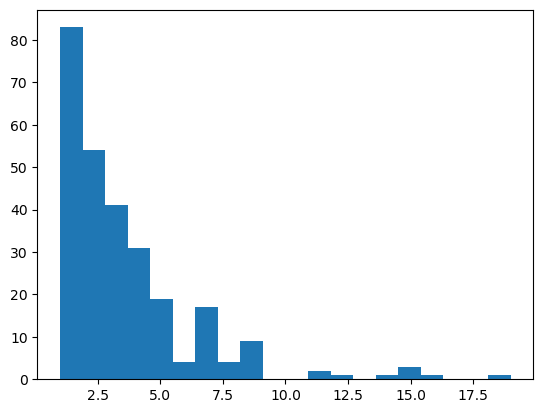

In [94]:
# in degree
plt.hist(dict(one_in_graph.in_degree).values(), bins=20);

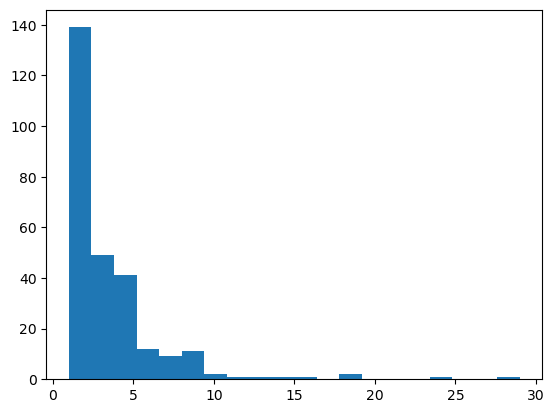

In [95]:
# out degree
plt.hist(dict(one_in_graph.out_degree).values(), bins=20);

In [96]:
for x in Counter(dict(one_in_graph.in_degree).values()).most_common():
    print(x)

(1, 83)
(2, 54)
(3, 41)
(4, 31)
(5, 19)
(7, 17)
(9, 9)
(6, 4)
(8, 4)
(15, 3)
(11, 2)
(19, 1)
(12, 1)
(14, 1)
(16, 1)


In [97]:
for x in Counter(dict(one_in_graph.out_degree).values()).most_common():
    print(x)

(1, 79)
(2, 60)
(3, 49)
(4, 26)
(5, 15)
(6, 12)
(7, 9)
(8, 6)
(9, 5)
(19, 2)
(10, 2)
(29, 1)
(11, 1)
(13, 1)
(14, 1)
(15, 1)
(24, 1)


## Check that NANOG is in the largest connected component

In [98]:
nanog_ids = protein_names['NANOG']
for nanog_id in nanog_ids:
    nanog_id = nanog_id
    if nanog_id in one_in_graph:
        print(nanog_id, one_in_graph.in_degree[nanog_id], one_in_graph.out_degree[nanog_id])

ENSMUSP00000012540 15 13


## Export connected component in gephi compatible format

In [99]:
all_attrs = set()
for edge in one_in_graph.edges(data=True):
    src, tgt, attrs = edge
    for key in attrs.keys():
        all_attrs.add(key)

In [100]:
all_attrs = list(all_attrs)

In [101]:
edgefile = open('../data/connected_graph_edges.csv','w')
edgefile.write('Source,Target,'+','.join(all_attrs)+'\n')
for edge in one_in_graph.edges(data=True):
    src, tgt, attrs = edge
    line = [src, tgt]
    for attr in all_attrs:
        if attr in attrs:
            line.append(attrs[attr])
        else:
            line.append('')

    edgefile.write(','.join([str(_) for _ in line]) + '\n')
edgefile.close()

In [102]:
nodefile = open('../data/connected_graph_nodes.csv','w')
nodefile.write('Id,Label\n')
for node in one_in_graph.nodes():
    if node in protein_id_names:
        node_name = '/'.join(protein_id_names[node])
    nodefile.write(node + ',' + node_name + '\n')

nodefile.close()

## Export graph as pickle

In [103]:
pickle.dump(one_in_graph, open('../data/filtered_graph.pickle','wb'))